# I. Introduction

This exercise implements a KNN algorithm 'from scratch' and explores possible k-values as well as different tie-breaker solutions for the iris dataset from scikit-learn.

First we import helpful packages.

In [19]:
import numpy as np
from sklearn import datasets
import pandas as pd
from heapq import nsmallest
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

# II. Loading & Exploring the Data

Then we load the iris dataset from scikit-learn, convert it into a pandas Dataframe for easier manipulation, and determine the number of each 'target' value.

In [104]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [105]:
iris_df['target'].value_counts()

2.0    50
1.0    50
0.0    50
Name: target, dtype: int64

Before we implement the KNN algorithm, let's first take a look at target classification by sets of our predictors.

<IPython.core.display.Javascript object>


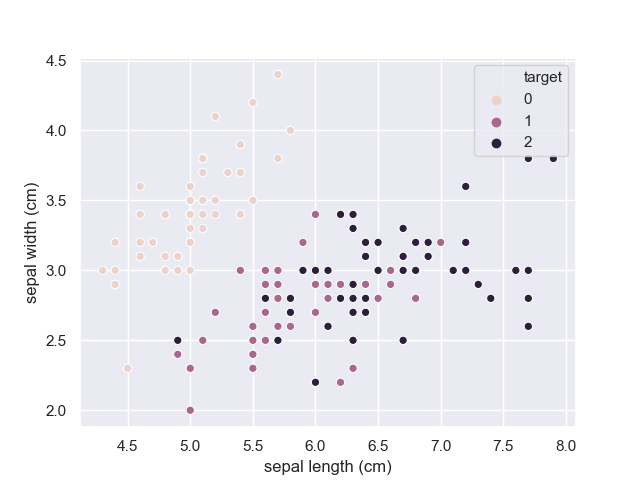

In [106]:
iris_df["target"] = iris_df["target"].astype(int)
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data = iris_df, x = 'sepal length (cm)', y = 'sepal width (cm)', hue = 'target')

<IPython.core.display.Javascript object>


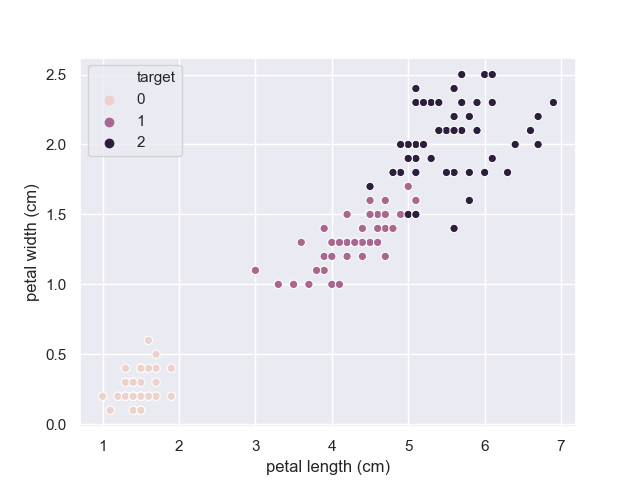

In [101]:
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data = iris_df, x = 'petal length (cm)', y = 'petal width (cm)', hue = 'target')

The plots indicate that KNN would be a good algorithm to employ on this data due to the high-level of grouping of similar colors ('target' values).

# III. Defining KNN

Our KNN algorithm was implemented with the use of smaller helper functions.

First, we know that we'll need to calculate distances between any 2 records from the iris dataset, so first we create a distance function which takes in two pandas series of predictor variables (derived from Dataframe rows) and returns the 'distance' between them.

In [107]:
def sarahs_dist_formula(rec1, rec2):
    diff = rec1 - rec2
    squared = diff**2
    summed = sum(squared)
    return np.sqrt(summed)

And now for a quick spot check test...

In [108]:
print(sarahs_dist_formula(iris_df.iloc[1,:4], iris_df.iloc[1,:4]))
print(sarahs_dist_formula(iris_df.iloc[1,:4], iris_df.iloc[2,:4]))

0.0
0.30000000000000016


Looks good.

Next, we'll need a complete 'distance matrix' that stores the distances between all pairs of records.  We chose to store these distances in a nested dictionary for easy future lookups.

In [109]:
def sarahs_dist_dict(predictors):
    dist_dict = {}
    # first creates the nested dictionaries so we can store the distances as we calculate them
    for record in predictors.index:
        dist_dict[record] = {}
    # cycles through each combination of different records, calculates the distance and stores it in both appropriate locations
    for record1 in predictors.index:
        for record2 in predictors[record1+1:].index:
            dist = sarahs_dist_formula(predictors.iloc[record1], predictors.iloc[record2])
            dist_dict[record1][record2] = dist
            dist_dict[record2][record1] = dist
    return dist_dict

Again, a quick spot check test...

In [110]:
temp = sarahs_dist_dict(iris_df.iloc[:,:4])
temp_df = pd.DataFrame(temp)
print(temp_df.shape)
temp_df.head()

(150, 150)


0         1         2         3         4         5         6    \
0       NaN  0.538516  0.509902  0.648074  0.141421  0.616441  0.519615   
1  0.538516       NaN  0.300000  0.331662  0.608276  1.090871  0.509902   
2  0.509902  0.300000       NaN  0.244949  0.509902  1.086278  0.264575   
3  0.648074  0.331662  0.244949       NaN  0.648074  1.166190  0.331662   
4  0.141421  0.608276  0.509902  0.648074       NaN  0.616441  0.458258   

        7         8         9      ...          140       141       142  \
0  0.173205  0.921954  0.469042    ...     5.019960  4.636809  4.208325   
1  0.424264  0.509902  0.173205    ...     5.072475  4.702127  4.180909   
2  0.412311  0.435890  0.316228    ...     5.228767  4.868265  4.334743   
3  0.500000  0.300000  0.316228    ...     5.104900  4.760252  4.177320   
4  0.223607  0.921954  0.529150    ...     5.061620  4.686150  4.246175   

        143       144       145       146       147       148       149  
0  5.257376  5.136146  4.654031  4.276681  4.459821  4.650806  4.140048  
1  5.320714  5.206726  4.700000  4.249706  4.498889  4.718050  4.153312  
2  5.475400  5.353504  4.864155  4.430576  4.661545  4.848711  4.298837  
3  5.349766  5.232590  4.745524  4.288356  4.533211  4.719110  4.149699  
4  5.297169  5.173007  4.701064  4.330127  4.504442  4.678675  4.173727  

[5 rows x 150 columns]

Looks good.

Next, we know we'll need to determine the appropriate target value prediction for each individual record.  The next two functions take in the distance dictionary for a single record (via index), the full 'target' pandas series, and the k-value we want the prediction to be based on.

In rare cases, but particularly with 3 classification values, there may be ties for which 'target' class has the highest presence among a record's k nearest neighbors.  We implement two versions for resolving the tie.
1. Version 1 implements a recursive(!) solution and re-calculates the max count class with k+1 neighbors
2. Version 2 sums the distances for each of the target classes with the equally highest counts among the k nearest neighbors and picks the class with the smallest total distance among the same k neighbors

We'll explore both versions when running our KNN algorithms and investigating the results.

In [111]:
def sarahs_knn_single_prediction_v1(records_dict, target, k):
    indeces = nsmallest(k, records_dict, key = records_dict.get)
    class_counts = target[indeces].value_counts()
    if len(class_counts[class_counts==class_counts.max()]) > 1:
        new_guess = sarahs_knn_single_prediction_v1(records_dict, target, k+1) #ooo recursion!
        return new_guess
    else:
        return class_counts.idxmax()

In [112]:
def sarahs_knn_single_prediction_v2(records_dict, target, k):
    indeces = nsmallest(k, records_dict, key = records_dict.get)
    class_counts = target[indeces].value_counts()
    if len(class_counts[class_counts==class_counts.max()]) > 1:
        # first we filter the class counts to only those with equally 'max' counts
        val_class_count = class_counts[class_counts==class_counts.max()]
        # then we filter the indeces of the neighbors to only those with those highest class counts
        filtered_targs = target[indeces][target[indeces].isin(list(val_class_count.index))]
        filtered_indeces = list(filtered_targs.index)
        # next we create a mini dictionary of only those indeces and their distances with the record we're trying to predict...
        dists = {ind:records_dict[ind] for ind in filtered_indeces}
        # and convert it to a pandas Dataframe for easier manipulation
        dists = pd.DataFrame.from_dict(dists, orient='index', columns = ['dist_value'])
        # we joins this Dataframe of distance values with the corresponding indeces 'target' values
        tot = dists.join(target[indeces])
        # sum the distances by target value
        tot_summed = tot.groupby('target').sum()
        # determin the minimum distance
        tot_summed_min_dist = min(tot_summed['dist_value'])
        # and find the target value with that minimum distance
        new_guess = tot_summed[tot_summed['dist_value'] == tot_summed_min_dist].index[0]
        return new_guess
    else:
        return class_counts.idxmax()

Another quick spot check test... 

Through data exploration, we determined that when k = 4, running the basic knn algorithm on the record at index 133 results in a tie between target classes '1' and '2'.  Thus, we use this index as our test case.

In [113]:
test_indeces = nsmallest(4, temp[133], key = temp[133].get)
test_class_counts = iris_df.loc[:, 'target'][test_indeces].value_counts()
test_class_counts

2    2
1    2
Name: target, dtype: int64

In [114]:
print(sarahs_knn_single_prediction_v1(temp[133], iris_df.loc[:, 'target'], 4))
print(sarahs_knn_single_prediction_v2(temp[133], iris_df.loc[:, 'target'], 4))

2
1


Interesting!  In this case, our two tie-breaker solutions yield different results!

Lastly, we wrap our helper functions into two comprehensive knn solution functions -- one for each tie-breaker method -- which both take a Dataframe of predictors, the outcome variable Series, and a k value, and return a list (in order) of predicted classes.

In [115]:
def sarahs_knn_v1(predictors, outcome, k):
    dist_dict = sarahs_dist_dict(predictors)
    predictions = []
    for record in dist_dict.keys():
        predictions.append(sarahs_knn_single_prediction_v1(dist_dict[record], outcome, k))
    return predictions

def sarahs_knn_v2(predictors, outcome, k):
    dist_dict = sarahs_dist_dict(predictors)
    predictions = []
    for record in dist_dict.keys():
        predictions.append(sarahs_knn_single_prediction_v2(dist_dict[record], outcome, k))
    return predictions

In [116]:
# just to help demonstrate testing
from collections import Counter

v1_results = sarahs_knn_v1(iris_df.iloc[:,:4], iris_df['target'], 4)
v2_results = sarahs_knn_v2(iris_df.iloc[:,:4], iris_df['target'], 4)

print(Counter(v1_results))
print(Counter(v2_results))

Counter({2: 51, 0: 50, 1: 49})
Counter({0: 50, 1: 50, 2: 50})


Given that we know the three target classes all appear 50 times in the actual data, these results (on the surface) look pretty reasonable!

# IV. Running KNN and Organizing the Results

Now that our KNN algorithms have been instantiated, we can run them for any k-values we choose and append the results as new columns in our iris Dataframe.  For demonstration purposes, we'll run them for a wide range of k values.

__Please note!:__  This code may take a while to run.  If you'd like the following code to finish quicker, limit the 'range' values in the for loop below.

In [117]:
iris_df_results = iris_df

for k_val in range(1,76):
    v1_string = 'v1_' + 'k_is_' + str(k_val)
    v2_string = 'v2_' + 'k_is_' + str(k_val)
    iris_df_results[v1_string] = sarahs_knn_v1(iris_df.iloc[:,:4], iris_df['target'], k_val)
    iris_df_results[v2_string] = sarahs_knn_v2(iris_df.iloc[:,:4], iris_df['target'], k_val)

iris_df_results.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  v1_k_is_1  v2_k_is_1  v1_k_is_2  v2_k_is_2  v1_k_is_3     ...      \
0       0          0          0          0          0          0     ...       
1       0          0          0          0          0          0     ...       
2       0          0          0          0          0          0     ...       
3       0          0          0          0          0          0     ...       
4       0          0          0          0          0          0     ...       

   v1_k_is_71  v2_k_is_71  v1_k_is_72  v2_k_is_72  v1_k_is_73  v2_k_is_73  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   v1_k_is_74  v2_k_is_74  v1_k_is_75  v2_k_is_75  
0           0           0           0           0  
1           0           0           0           0  
2           0           0           0           0  
3           0           0           0           0  
4           0           0           0           0  

[5 rows x 155 columns]

Now that we've captured the KNN predictions, what we really care about is the accuracy of each run of the algorithm, not necessarily the predictions themselve.  As such, we convert all the newly created columns to booleans representing whether our prediction was correct or not.

In [118]:
for k_val in range(1,76):
    v1_string = 'v1_' + 'k_is_' + str(k_val)
    v2_string = 'v2_' + 'k_is_' + str(k_val)
    iris_df_results[v1_string] = iris_df_results[v1_string] == iris_df_results['target']
    iris_df_results[v2_string] = iris_df_results[v2_string] == iris_df_results['target']

iris_df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  v1_k_is_1  v2_k_is_1  v1_k_is_2  v2_k_is_2  v1_k_is_3     ...      \
0       0       True       True       True       True       True     ...       
1       0       True       True       True       True       True     ...       
2       0       True       True       True       True       True     ...       
3       0       True       True       True       True       True     ...       
4       0       True       True       True       True       True     ...       

   v1_k_is_71  v2_k_is_71  v1_k_is_72  v2_k_is_72  v1_k_is_73  v2_k_is_73  \
0        True        True        True        True        True        True   
1        True        True        True        True        True        True   
2        True        True        True        True        True        True   
3        True        True        True        True        True        True   
4        True        True        True        True        True        True   

   v1_k_is_74  v2_k_is_74  v1_k_is_75  v2_k_is_75  
0        True        True        True        True  
1        True        True        True        True  
2        True        True        True        True  
3        True        True        True        True  
4        True        True        True        True  

[5 rows x 155 columns]

We now have a record of whether each individual record was correctly or incorrectly predicted with each run of the algorithm(s).  To calculate overall accuracy of each run, we create a new 'results' dictionary.  For each k value, we capture that k-value, the accuracy of the 'V1' algorithm, and the accuracy of the 'V2' algorithm.

In [119]:
df_len = len(iris_df_results)
results_dict = {}
for k_val in range(1,76):
    v1_string = 'v1_' + 'k_is_' + str(k_val)
    v2_string = 'v2_' + 'k_is_' + str(k_val)
    results_dict[k_val] = [k_val, sum(iris_df_results[v1_string])/df_len, sum(iris_df_results[v2_string])/df_len]

[results_dict[x] for x in range(1,11)]

[[1, 0.96, 0.96],
 [2, 0.96, 0.96],
 [3, 0.96, 0.96],
 [4, 0.9666666666666667, 0.96],
 [5, 0.9666666666666667, 0.9666666666666667],
 [6, 0.9666666666666667, 0.96],
 [7, 0.9666666666666667, 0.9666666666666667],
 [8, 0.9666666666666667, 0.9666666666666667],
 [9, 0.9666666666666667, 0.9666666666666667],
 [10, 0.9733333333333334, 0.9533333333333334]]

Lastly, we convert the dictionary of results into pandas dataframe for easier exploration and visualization.

In [120]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['k_value', 'V1','V2'])
results_df.head()

k_value        V1        V2
1        1  0.960000  0.960000
2        2  0.960000  0.960000
3        3  0.960000  0.960000
4        4  0.966667  0.960000
5        5  0.966667  0.966667

# V. Results Exploration & Discussion

Now we get to graph the results.  We'll start by graphing the 'Function Time' on the y-axis versus the number of items in the knapsack problem.  Results are color-coded based on the the solution methodology used.

In [123]:
results_melted = pd.melt(results_df, id_vars='k_value', var_name="Version", value_vars=['V1','V2'], value_name="Accuracy")
results_melted.head()

k_value Version  Accuracy
0        1      V1  0.960000
1        2      V1  0.960000
2        3      V1  0.960000
3        4      V1  0.966667
4        5      V1  0.966667

<IPython.core.display.Javascript object>


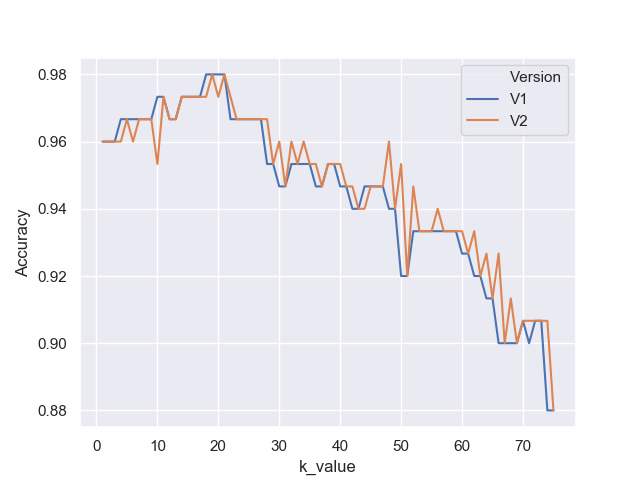

In [124]:
plt.figure()
sns.set(style="darkgrid")
sns.lineplot(x='k_value', y='Accuracy', hue = 'Version', data = results_melted)

Clearly, once the number of items surpasses ~25, the recursive function starts taking a __*lot*__ longer to complete.  

Thus, let's see what the results look like when we filter to knapsack problems with 25 or fewer items...

<IPython.core.display.Javascript object>


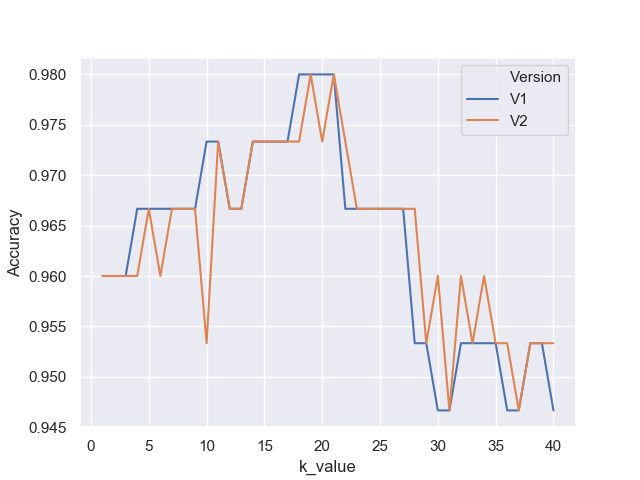

In [125]:
plt.figure()
sns.set(style="darkgrid")
sns.lineplot(x='k_value', y='Accuracy', hue = 'Version', data = results_melted[results_melted['k_value']<=40])

<IPython.core.display.Javascript object>


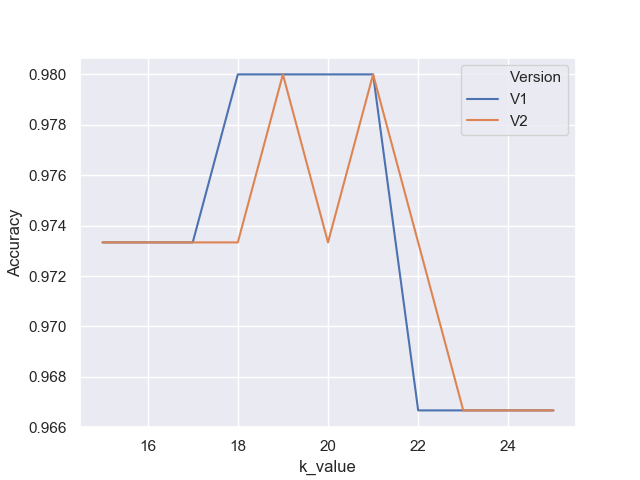

In [92]:
plt.figure()
sns.set(style="darkgrid")
sns.lineplot(x='k_value', y='Accuracy', hue = 'Version', data = results_melted[(results_melted['k_value']>=15) & (results_melted['k_value']<=25)])

In [129]:
best_v_and_k = 'v1_' + 'k_is_' + str(19)
iris_df_results[best_v_and_k].value_counts()

True     147
False      3
Name: v1_k_is_19, dtype: int64

<IPython.core.display.Javascript object>


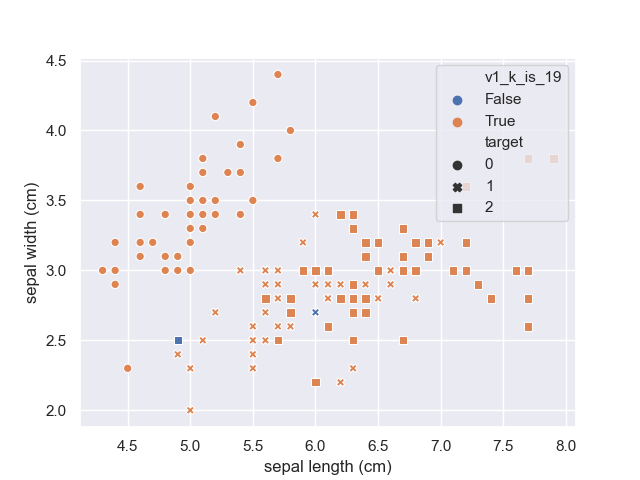

In [135]:
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data=iris_df_results, x='sepal length (cm)', y='sepal width (cm)', hue=best_v_and_k, style='target', legend = 'brief')

<IPython.core.display.Javascript object>


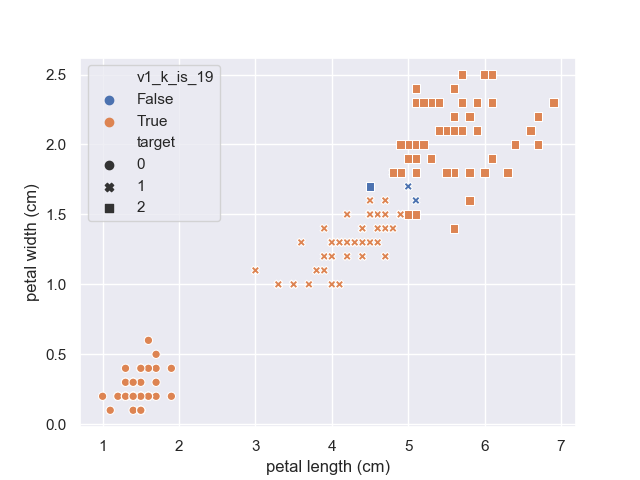

In [127]:
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data=iris_df_results, x='petal length (cm)', y='petal width (cm)', hue=best_v_and_k, style='target')
# all set!

Since as the number of items increases, the recursive function takes *so* long to run, removing the recursive records from our results allows us to see that on a much smaller scale, the same is true for Dynamic Programming.  The Greedy algorithm is consistently much faster than both the alternatives as the number of items increases.

However, we know there is a downside to the speed of the Greedy algorithm.  Let's now create an additional column in our results dataframe to record how far the function's final knapsack value result is from the optimal knapsack value.  We know that the recursive method and the dynamic programming methods both return the optimal knapsack, so we'll use those results as a comparison.  This exercise is primarly to explore what we'll call the 'accuracy' or % of knapsack value optimality of the Greedy method as the number of items in the problem increase.

Here we see the downside to the Greedy method.  

For the first few test cases (as well as other cases on occassion based on the randomly generated data in those cases), the greedy algorthm performs well and returns the optimal knapsack.

However, as the number of items increase, so the variability in the 'accuracy' of the Greedy algorithm.  The Greedy algorithm performs particularly poorly with the case with 19 items to consider.  

Something to note, though, is the y-axis scale.  The worst 'accuracy' is just below 80% and for 25 out of 26 cases the greedy algorithm gets within 90% of the optimal knapsack value.  

In summary, we can say that the recursive method should basically never be used to solve the knapsack problem.  The Dynamic Programming method will return the same results and will take the same or less time to return results in virtually all cases.
In certain specific circumstances, however, one *might* still choose to leverage the greedy algorithm... when time is major factor and value results within *roughly* 90% of the optimal result are all that is required.  Overall, though, dynamic programming offers a pretty powerful solution to an NP Complete problem like the knapsack problem.